In [1]:
import os

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, linear_model

sns.set_style("darkgrid")

Data source: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

# Get historical data

In [2]:
filepath = os.path.join("..", "data", "bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [3]:
df = pd.read_csv(filepath)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


## Convert timestamps to datatime objects and set as index

In [5]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
df = df.set_index("Timestamp", drop=True)
df = df[df.index > pd.to_datetime('2012-01-01')]

## Check for null values

<AxesSubplot: ylabel='Timestamp'>

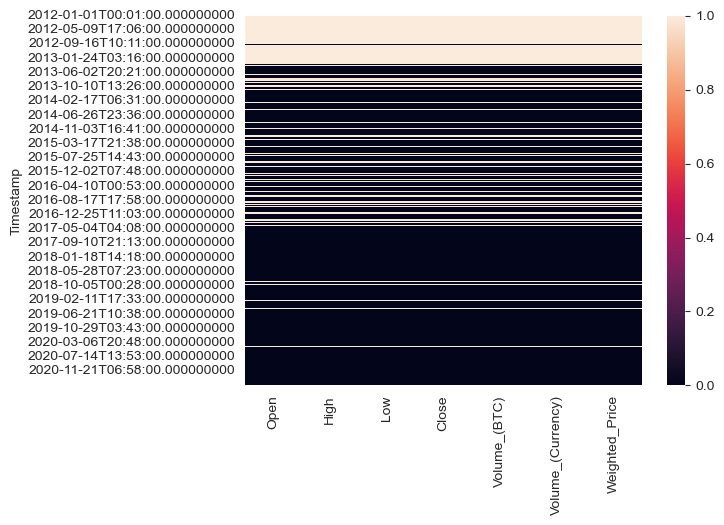

In [6]:
sns.heatmap(df.isnull())

## Drop null values

In [7]:
df = df.dropna().reset_index().set_index("Timestamp", drop=True)

<AxesSubplot: ylabel='Timestamp'>

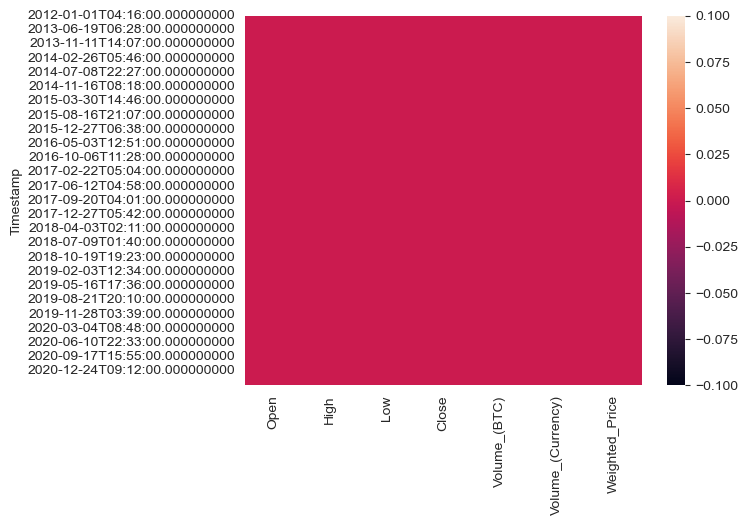

In [8]:
sns.heatmap(df.isnull())

## Check for outliers

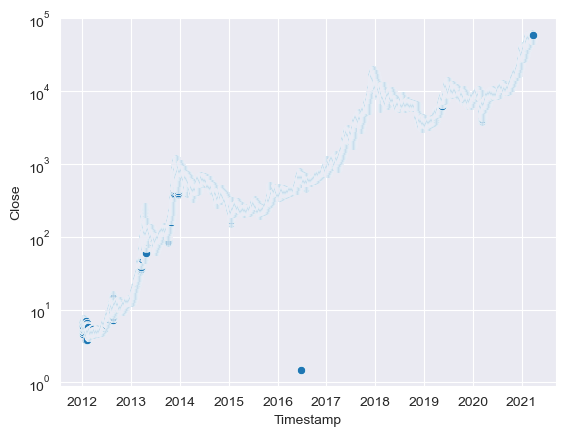

In [9]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

## Resample data
Since we don't really need minute data for our analysis, we can just resample and see if it disappears

In [10]:
df = df.resample("BMS").apply({
    'Open'  : 'first',
    'High'  : 'max',
    'Low'   : 'min',
    'Close' : 'last',
})

No more outliers in monthly data

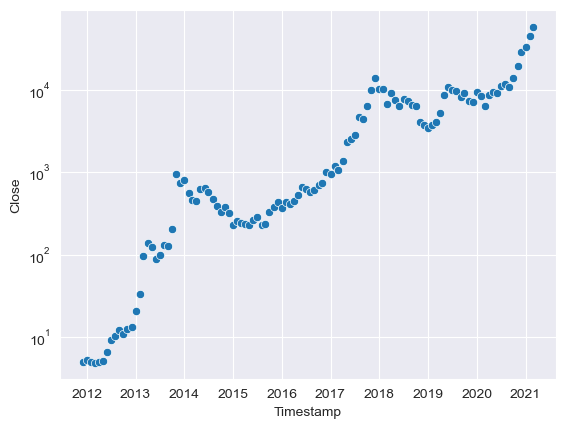

In [11]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

In [12]:
df.tail()

,Open,High,Low,Close
Timestamp,,,,
2020-11-02,13762.00,19864.15,13220.00,19700.19
2020-12-01,19703.53,29300.00,17569.58,28992.79
2021-01-01,28999.63,42000.00,27734.00,33141.38
2021-02-01,33110.32,58354.14,32333.01,45240.96
2021-03-01,45261.56,61781.83,45020.25,58778.18


However, the data is not the most recent, only until Mar 2021. Lets get the latest data

# Get latest data and concatenate

In [13]:
df2 = web.get_data_yahoo("BTC-USD", interval="m", start=df.index[-1] + pd.Timedelta(days=31))

In [14]:
df2 = df2.drop(["Volume", "Adj Close"], axis=1)

In [15]:
df = pd.concat([df, df2])

# Plot

Text(0.5, 0, 'Time')

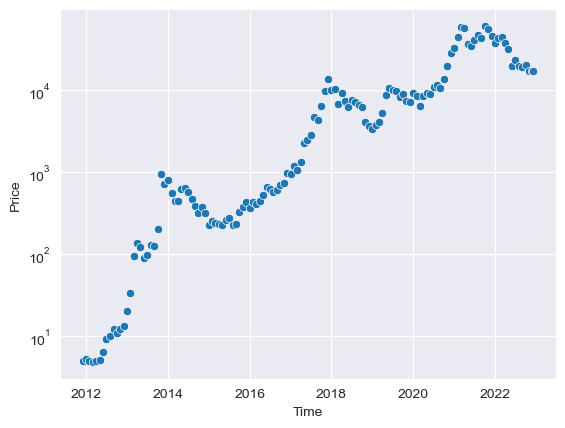

In [16]:
ax = sns.scatterplot(x=df.index, y="Close", data=df)
ax.set_yscale("log")

ax.set_ylabel("Price")
ax.set_xlabel("Time")

## Monthly returns

Text(0.5, 0, 'Time')

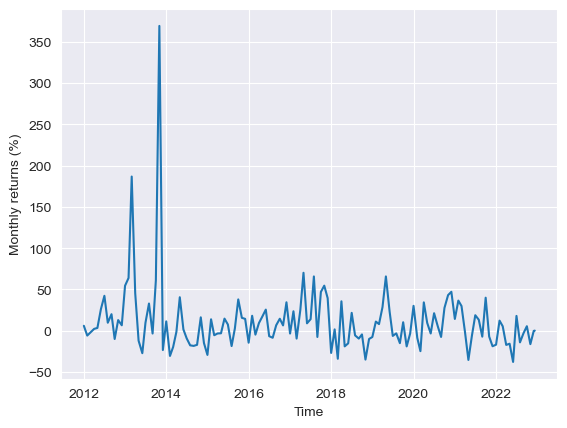

In [17]:
ax = sns.lineplot(x=df.index, y=df["Close"].pct_change() * 100)

ax.set_ylabel("Monthly returns (%)")
ax.set_xlabel("Time")

# Calculate volatility

In [18]:
months_in_window = 3
months_in_year = 12
annualization_factor = months_in_year / months_in_window

$$  $$

## Method 1 

In [19]:
df['log_rtn_close'] = np.log(df["Close"] / df["Close"].shift(1))
df.fillna(0, inplace = True)
df['real_volatility_close'] = df['log_rtn_close'].rolling(window=months_in_window).std(ddof=0) * np.sqrt(months_in_year)

## Method 2

In [20]:
df['log_rtn_close'] = np.log(df['Close']).diff()
df['real_volatility_close'] = np.sqrt(np.square(df['log_rtn_close']).rolling(months_in_window).sum() * annualization_factor)

Convert datetime index to number of months from starting date, x data needs to be reshaped for sklearn fitting

In [21]:
x = df.index[months_in_window:].factorize()[0].reshape(-1, 1)
y = df["real_volatility_close"].values[months_in_window:]

In [22]:
len(x) == len(y)

True

Fit with linear regression model

In [23]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

Text(0.5, 0, 'Time')

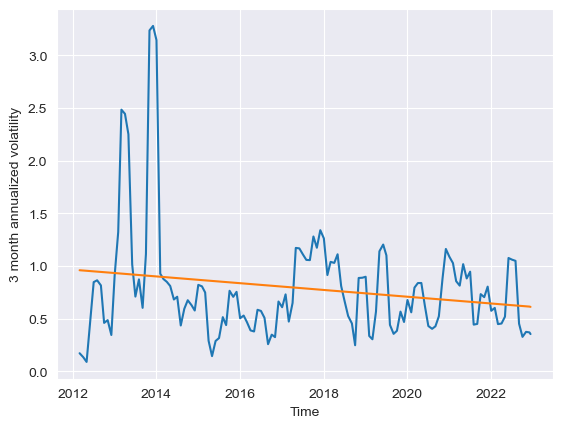

In [24]:
ax = sns.lineplot(x=df.index, y="real_volatility_close", data=df)
sns.lineplot(x=df.index[months_in_window:], y=regr.predict(x), color="C1", ax=ax)

ax.set_ylabel("3 month annualized volatility")
ax.set_xlabel("Time")

The data is quite clear that the 3 month annualized volatility of BTC is decreasing 

# Comparison with SPY volatility

In [25]:
spy = web.get_data_yahoo("SPY", interval="m", start=df.index[0])

In [26]:
spy['log_rtn_close'] = np.log(spy["Close"] / spy["Close"].shift(1))
spy.fillna(0, inplace = True)
spy['real_volatility_close'] = spy['log_rtn_close'].rolling(window=months_in_window).std(ddof=0) * np.sqrt(12)

## Fit SPY volatility

In [27]:
x_spy = spy.index[months_in_window:].factorize()[0].reshape(-1, 1)
y_spy = spy["real_volatility_close"].values[months_in_window:]

regr_spy = linear_model.LinearRegression()
regr_spy.fit(x_spy, y_spy)

LinearRegression()

Text(0.5, 0, 'Time')

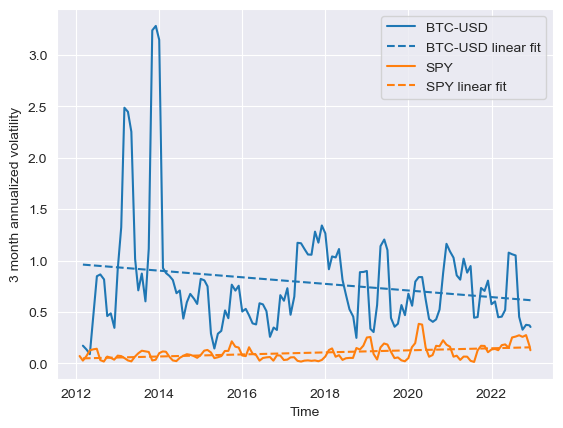

In [28]:
ax = sns.lineplot(x=df.index, y="real_volatility_close", data=df, label="BTC-USD")
sns.lineplot(x=df.index[months_in_window:], y=regr.predict(x), linestyle="--", color="C0", ax=ax, label="BTC-USD linear fit")

sns.lineplot(x=spy.index, y="real_volatility_close", data=spy, ax=ax, label="SPY")
sns.lineplot(x=spy.index[months_in_window:], y=regr_spy.predict(x_spy), linestyle="--", color="C1", ax=ax, label="SPY linear fit")

ax.set_ylabel("3 month annualized volatility")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

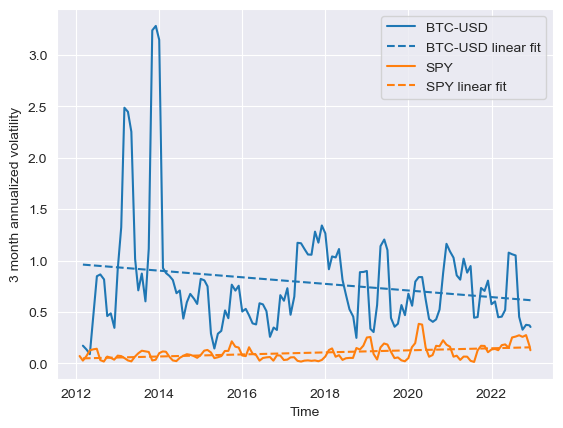

In [29]:
ax = sns.lineplot(x=df.index, y="real_volatility_close", data=df, label="BTC-USD")
sns.lineplot(x=df.index[months_in_window:], y=regr.predict(x), linestyle="--", color="C0", ax=ax, label="BTC-USD linear fit")

sns.lineplot(x=spy.index, y="real_volatility_close", data=spy, ax=ax, label="SPY")
sns.lineplot(x=spy.index[months_in_window:], y=regr_spy.predict(x_spy), linestyle="--", color="C1", ax=ax, label="SPY linear fit")

ax.set_ylabel("3 month annualized volatility")
ax.set_xlabel("Time")

# Relative volatility

In [30]:
x_rel = spy.index[months_in_window:].factorize()[0].reshape(-1, 1)
y_rel = df["real_volatility_close"][months_in_window:].values / spy["real_volatility_close"][months_in_window:].values

regr_rel = linear_model.LinearRegression()
regr_rel.fit(x_rel, y_rel)

LinearRegression()

Text(0.5, 0, '')

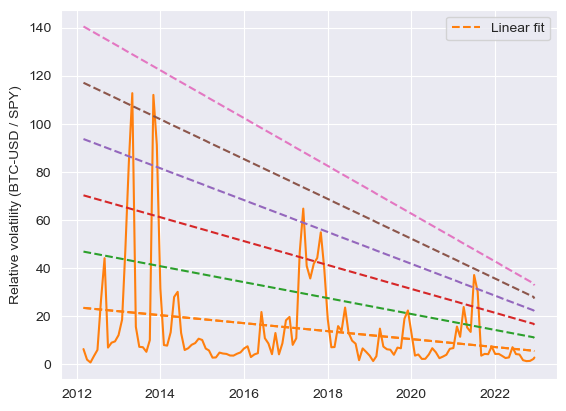

In [31]:
ax = sns.lineplot(x=spy.index, y=df["real_volatility_close"].values / spy["real_volatility_close"].values, color="C1")
sns.lineplot(x=spy.index[months_in_window:], y=regr_rel.predict(x_rel), color="C1", ax=ax, linestyle="--", label="Linear fit")

for i in np.arange(1, 7, 1):
    sns.lineplot(x=spy.index[months_in_window:], y=regr_rel.predict(x_rel) * i, ax=ax, color=f"C{i}", linestyle="--")

ax.set_ylabel("Relative volatility (BTC-USD / SPY)")
ax.set_xlabel("")

# Fanciful projections

In [32]:
x_extrapolation = pd.date_range(start=spy.index[0], periods=175, freq="m")

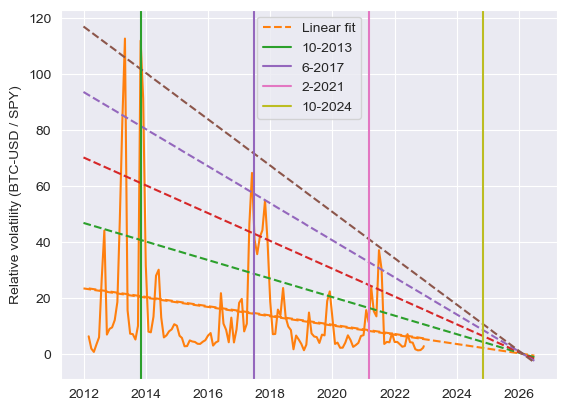

In [33]:
ax = sns.lineplot(x=spy.index, y=df["real_volatility_close"].values / spy["real_volatility_close"].values, color="C1")
sns.lineplot(x=spy.index[months_in_window:], y=regr_rel.predict(x_rel), color="C1", ax=ax, linestyle="--", label="Linear fit")

for i in np.arange(1, 6, 1):
    sns.lineplot(x=x_extrapolation, y=regr_rel.predict(x_extrapolation.factorize()[0].reshape(-1, 1)) * i, ax=ax, color=f"C{i}", linestyle="--")

ax.set_ylabel("Relative volatility (BTC-USD / SPY)")
ax.set_xlabel("")

cycle_start = 22
progression = [1, 3, 5, 7]

for i in progression:
    peak = x_extrapolation[cycle_start * i]
    ax.axvline(peak, label=f"{peak.month}-{peak.year}", color=f"C{i+1}")

ax.legend()

In [34]:
f"Prediction of a cycle peak around end of {x_extrapolation[cycle_start * 7].year}, with a relative volatility peak of {int(regr_rel.predict(x_extrapolation.factorize()[0].reshape(-1, 1))[22*7] * 5)}"

'Prediction of a cycle peak around end of 2024, with a relative volatility peak of 10'